In [2]:
# IMPORTS
import torch


# import scipy.special
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as TF

# import torch.optim as optim
# import torch.nn.functional as F
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import peak_signal_noise_ratio as psnr
import libs.forward_model as fm
import libs.read_data as rd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Parameters

In [3]:
# Parameter Definition
NA = .25
Rindex= 1
lambda_= 532.0/ 1000 #um
dx= 2.0 #um

Nx,Ny,Nz = 4,4,4

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD()
rd.init_parameters(Nx,Ny,Nz)

Point Spread Function Initialization Failed...!!!
Sucessfully Initialized DMD Pattern...!!!
Sucessfully Initialized Read Data Parameters...!!!


### Forward Model

$$ H_1(x,y,z) = H(x,y,z=z_f)\ \star_{\tiny 3D}\ \texttt{exPSF}(x,y,z) \qquad\to\qquad H_2(x,y,z) = \|H_1(x,y,z)\|$$ 



$$H_3(x,y,z) = X(x,y,z) \circ H_2(x,y,z) \qquad \to \qquad Y(x,y,z) = \texttt{emPSF}(x,y,z)\ \star_{\tiny 3D}\ H_3(x,y,z)$$

The $\texttt{exPSF}(.)$ is modelled considering the coherance nature of laser light whereas the $\texttt{emPSF}(.)$ is defined in a incoherant manner<br>

[Image Data](https://bigwww.epfl.ch/deconvolution/bead/)

In [3]:
import libs.read_data as rd
rd.load_object("3D_sphere")

Failed to Load Object...!!!


0

In [8]:
rd.X.shape

torch.Size([1, 4, 4, 4])

## Approximation of A

$$Y_{\tiny N_x\cdot N_y\cdot m\times1} = A_{\tiny N_x\cdot N_y\cdot m\times N_x\cdot N_y\cdot N_z}\cdot X_{\tiny N_x\cdot N_y\cdot N_z\times 1}$$

In [898]:
m = 16
A = torch.zeros(Nx*Ny*m,Nx*Ny*Nz).float().to(device)

# Lets Fix Ht ~ # = m
Ht_2D_list = []

for _ in range(m):
    patch_size = max(min(Nx, Ny) // 20,1)
    Ht_2D = (torch.randn(Nx // patch_size, Ny // patch_size) > 0).float()
    Ht_2D = Ht_2D.repeat_interleave(patch_size , dim=0).repeat_interleave(patch_size, dim=1)[:Nx, :Ny]
    Ht_2D_list.append(Ht_2D)


def extended_forward_model(X):
    Y = torch.tensor([]).to(device)
    for Ht_2D in Ht_2D_list:
        Yi = forward_model(X,Ht_2D)
        Yi_flatten = Yi.flatten()
        Y = torch.cat((Y, Yi_flatten), dim=0)
    return Y

I = torch.zeros(1, Nz, Nx, Ny).float().to(device)
for i_z in range(Nz):
    for i_x in range(Nx):
        for i_y  in range(Ny):
            I[0,i_z,i_x,i_y] = 1
            A [:,i_z*Ny*Nx+ i_x*Ny+i_y] = extended_forward_model(I)
            I[0,i_z,i_x,i_y] = 0

def one_shot_model(X):
    return torch.matmul(A,X)

## Reconstruction
$$y=A\cdot x\implies b = (A^{\tiny T}\cdot A)\cdot x\qquad where\quad b = A^{\tiny T}\cdot y$$

In [899]:
ATA = (A.T@A).float()
print(f"Conditional Number: {torch.linalg.cond(ATA)}")
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")

Conditional Number: 4197494528.0
Rank : 186


***Basic Solution***

$$Y = A\cdot X \implies A^{\tiny T}\cdot Y  = (A^{\tiny T}\cdot A)\cdot X\implies X = (A^{\tiny T}\cdot A)^{-1}\cdot A^{\tiny T}\cdot Y  $$

In [900]:
def reconstruct_image_basic(y):
    A_pseudo_inv = torch.linalg.pinv(A)   # torch.linalg.pinv(A.T@A)@A.T
    return torch.matmul(A_pseudo_inv, y)

***LU Decomposition Based Solution***

In [901]:
def reconstruct_image_lu(y):
    b = (A.T@y).view(-1,1)
    LU, pivots = torch.lu(ATA)
    return torch.lu_solve(b, LU, pivots)

***Cholesky Decomposition Based Solution***

In [902]:
def reconstruct_image_ch(y):
    b = (A.T@y).view(-1,1)
    U = torch.cholesky(ATA, upper=False)
    return torch.cholesky_solve(b, U, upper=False)

***Gradient Descent Based***

$$x_0\xrightarrow{\texttt{Loss Calculation}}L =\| Ax_0 - b\|\xrightarrow{\texttt{Gradient Descent}}x_1\dots \to L=0$$ 

In [903]:
def reconstruct_image_gd(y, learning_rate = 1e-1, num_iter = 50000):
    # RANDOM INTIALIZATION OF X
    x = torch.autograd.Variable(torch.rand(Nx*Ny*Nz,1,dtype = torch.float32).to(device), requires_grad=True)

    # Define the optimizer
    optimizer = optim.SGD([x], lr=learning_rate)

    # Gradient descent optimization loop
    for iter in range(num_iter+1):
        loss = torch.norm(A@x-y,p=2)
        loss.backward()
        optimizer.step()
        if(iter%10000 == 0):
            print(f"At Iteration {iter} Error is: {loss}")
        optimizer.zero_grad()
    return x

***Results***

In [904]:
X_original = random_cube.flatten()
Y = one_shot_model(X_original)
X_reconstructed = torch.linalg.lstsq(A,Y).solution           #reconstruct_image_gd(Y)

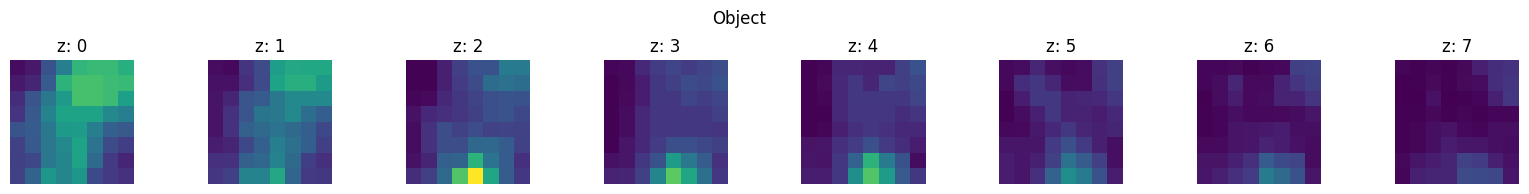

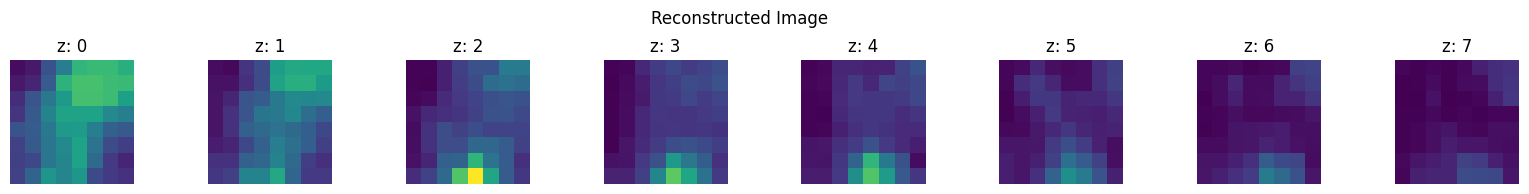

In [905]:
X3D_recons = X_reconstructed.view(Nz,Nx, Ny)
X3D_orig = X_original.view(Nz,Nx,Ny)
show_planes_z(X3D_orig.detach().cpu().numpy(),"Object",[i for i in range(Nz)])
show_planes_z(X3D_recons.detach().cpu().numpy(),"Reconstructed Image",[i for i in range(Nz)])

## Validation & Verification

### Experiments on Data

***Effect of Center Plane: Neural Data***

In [ ]:
random_cube_e1 = random_cube.clone()
random_cube_e1[0,40:60,:,:] = 0
show_planes_z(random_cube_e1.detach().cpu().numpy()[0,:,:,:],"Zero Center Plane",[0,12,24,36,50, 60,72,84,96])
det_image_e1=forward_model(random_cube_e1,Ht_2D,3)
print(f"SSIM(Original, Maksed Center Plane) : {ssim(det_image_orig.detach().cpu().float().numpy(),det_image_e1.detach().cpu().float().numpy())}")

***Only the Center Plane is Non-Zero***

In [ ]:
random_cube_e2 = random_cube.clone()
random_cube_e2[0,:50,:,:] = 0
random_cube_e2[0,51:,:,:] = 0
show_planes_z(random_cube_e2.detach().cpu().numpy()[0,:,:,:],"Non-Zero Only in Center Plane",[0,12,24,36,50, 60,72,84,96])
det_image_e2=forward_model(random_cube_e2,Ht_2D,3)
print(f"SSIM(Original, Focal Plane Object) : {ssim(det_image_orig.detach().cpu().float().numpy(),det_image_e2.detach().cpu().float().numpy())}")

***Slice-wise Comparision***

In [ ]:
SSIM_list = []
mask_centers = []
ws = 8 # WINDOWSIZE

for mask in range(Nz//ws+1):
    random_cube_exp = random_cube.clone()
    random_cube_exp[0,mask*ws:(mask+1)*ws,:,:] = 0
    det_image_exp = forward_model(random_cube_exp, Ht_2D, 0)
    SSIM_score = ssim(det_image_orig.detach().cpu().float().numpy(),det_image_exp.detach().cpu().float().numpy())
    SSIM_list.append(SSIM_score), mask_centers.append(mask*ws+ws/2)
    print(f"Mask Out z={mask*ws}\t->   z={(mask+1)*ws},\t SSIM_score = {SSIM_score} ")

plt.figure(figsize=(6, 6))  # Adjust the figure size if needed
plt.plot(mask_centers, SSIM_list, marker='o', linestyle='-')
plt.title(f'SSIM Scores (Window Size = {ws})')
plt.xlabel('Mask Center')
plt.ylabel('SSIM Score')
plt.grid(True)


### Visualization and Verification of A

***Visualization of A***

In [ ]:
A_ = A.detach().cpu().numpy()
A_[A_==0] = 1e-30
A_ = np.log(A_)
show_image(A_,fig_size=(6,6),title="A(Log Scale)")

***Verification of A***

In [ ]:
Y1 = extended_forward_model(random_cube)
Y2 = one_shot_model(random_cube.flatten())

tolerance = 1e-6
are_approx_equal = torch.allclose(Y1, Y2, atol=tolerance)

if are_approx_equal:
    print("The vectors are approximately the same.")
else:
    print("The vectors are different.")